# WOMEN'S CLOTHING DATA SET SENTIMENT ANALYSIS

1.Installing and importing all essential libraries initially

In [1]:
#pip install plotly
#pip show plotly
#pip install wordcloud
#pip install termcolor
#pip install pandas-profiling
#pip install cufflinks

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, accuracy_score, precision_score
import re  #this I learned from a Udemy course, which helps with regular expressions,can be used to check if a string contains the specified search pattern

import nltk #nlp toolkit
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud 


# Figure&Display options
%matplotlib inline
fig, ax = plt.subplots()

# fig.set_size_inches(10, 6)
plt.rcParams["figure.figsize"] = (12, 8)  # the size of A4 paper use (11.7, 8.27)
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# !pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored


# to make fancy df.describe()
import pandas_profiling
from pandas_profiling.report.presentation.flavours.html.templates import create_html_assets

# Importing plotly and cufflinks in to easily plot dfs
import cufflinks as cf
import plotly.express as px
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ezgi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ezgi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ezgi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2.Some Custom Functions to keep code dry and avoid repetition, these will be called in the following steps

In [3]:
#for missing values
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

#for initial analysis - similar to df.info() but much more custom
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    

# To view summary information about the column

def investigate(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(eda_df[col].isnull().sum()/eda_df.shape[0]*100, 2))
    print("num_of_nulls   : ", eda_df[col].isnull().sum())
    print("num_of_uniques : ", eda_df[col].nunique())
    print(eda_df[col].value_counts(dropna = False))
    

3.Importing the dataset and performing some initial data analysis to see what I am working with.

In [4]:
main_df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
eda_df = main_df.copy()
eda_df.head()

Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                                                                                                                                                                               Review Text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   
3                                                                             I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4         This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   

   Rating  Recommended IND  Positive Feedback Count   Division Name  \
0       4                1                        0       Initmates   
1       5                1                        4         General   
2       3                0                        0         General   
3       5                1                        0  General Petite   
4       5                1                        6         General   

  Department Name Class Name  
0        Intimate  Intimates  
1         Dresses    Dresses  
2         Dresses    Dresses  
3         Bottoms      Pants  
4            Tops    Blouses

In [5]:
#This part is so cool. So, here we see initial analysis of the data with just a one line of code. When I learned this one, I was so excited and like wow if I only knew it sooner:) 
eda_df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
first_looking(eda_df)

Shape:(23486, 11)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 1.5+ MB
None
------------------------------------------

In [7]:
eda_df.drop("unnamed:_0", axis=1, inplace=True)
eda_df.head(1)

clothing_id  age title  \
0          767   33   NaN   

                                             review_text  rating  \
0  Absolutely wonderful - silky and sexy and comfortable       4   

   recommended_ind  positive_feedback_count division_name department_name  \
0                1                        0     Initmates        Intimate   

  class_name  
0  Intimates

In [8]:
#To find out more about object type features 
eda_df.describe(include=object).T

count unique  \
title            19676  13993   
review_text      22641  22634   
division_name    23472      3   
department_name  23472      6   
class_name       23472     20   

                                                                                                top  \
title                                                                                      Love it!   
review_text      Perfect fit and i've gotten so many compliments. i buy all my suits from here now!   
division_name                                                                               General   
department_name                                                                                Tops   
class_name                                                                                  Dresses   

                  freq  
title              136  
review_text          3  
division_name    13850  
department_name  10468  
class_name        6319

In [9]:
# to find how many unique values numerical features have
for col in eda_df.select_dtypes(include=[np.number]).columns:
  print(colored(f"{col}", 'green', attrs=['bold']), f"feature has", colored(f"{eda_df[col].nunique()}", 'green', attrs=['bold']), f"unique values.")

clothing_id feature has 1206 unique values.
age feature has 77 unique values.
rating feature has 5 unique values.
recommended_ind feature has 2 unique values.
positive_feedback_count feature has 82 unique values.


In [10]:
# to find how many unique values object features have

for col in eda_df.select_dtypes(include="object").columns:
  print(colored(f"{col}", 'green', attrs=['bold']), f"feature has", colored(f"{eda_df[col].nunique()}", 'green', attrs=['bold']), f"unique values.")

title feature has 13993 unique values.
review_text feature has 22634 unique values.
division_name feature has 3 unique values.
department_name feature has 6 unique values.
class_name feature has 20 unique values.


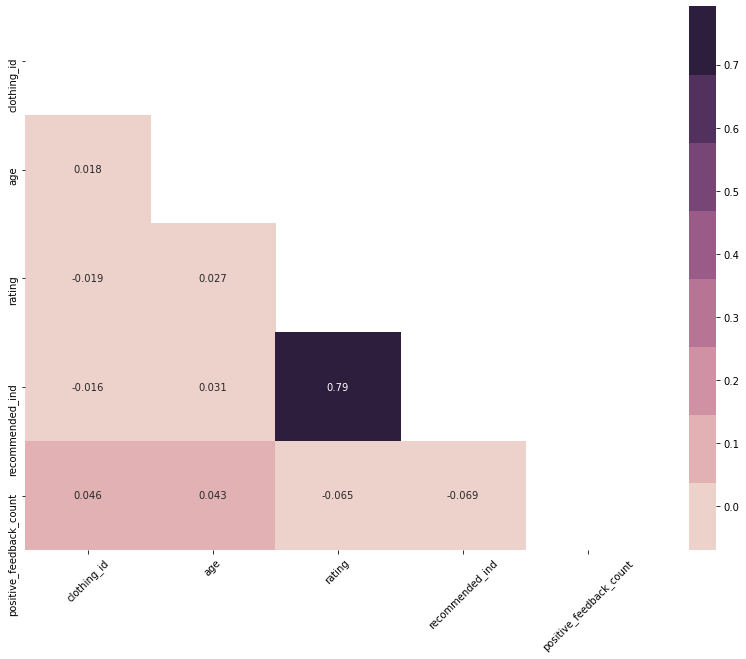

In [11]:
#lets see if there are correlations between our columns
plt.figure(figsize=(14, 10))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(eda_df.corr())

# using the upper triangle matrix for heatmap as mask
sns.heatmap(eda_df.corr(), annot=True, cmap = sns.cubehelix_palette(8), mask=matrix)

plt.xticks(rotation=45);

4.Target variable examination

In [12]:
eda_df.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

In [13]:
eda_df.head(5)

clothing_id  age                    title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                                                                                                                                                                               review_text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   
3                                                                             I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4         This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   

   rating  recommended_ind  positive_feedback_count   division_name  \
0       4                1                        0       Initmates   
1       5                1                        4         General   
2       3                0                        0         General   
3       5                1                        0  General Petite   
4       5                1                        6         General   

  department_name class_name  
0        Intimate  Intimates  
1         Dresses    Dresses  
2         Dresses    Dresses  
3         Bottoms      Pants  
4            Tops    Blouses

In [14]:
#"recommended_ind" is a binary variable, 1 is recommended, 0 is not recommended.
eda_df["recommended_ind"].value_counts()

1    19314
0     4172
Name: recommended_ind, dtype: int64

In [15]:
investigate("recommended_ind")

column name    :  recommended_ind
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    19314
0     4172
Name: recommended_ind, dtype: int64


In [16]:
eda_df["recommended_ind"].describe().T

count   23486.00
mean        0.82
std         0.38
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: recommended_ind, dtype: float64

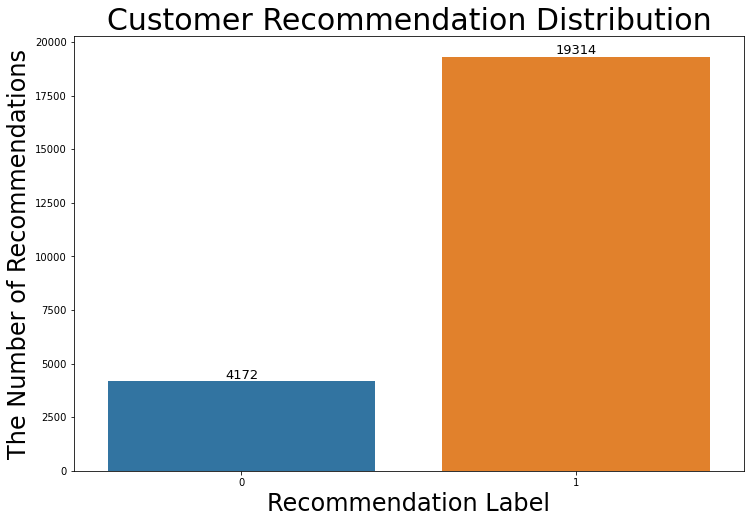

In [17]:
sns.countplot(x = eda_df.recommended_ind, data = eda_df)
plt.title('Customer Recommendation Distribution', fontsize=30)
plt.xlabel("Recommendation Label", fontsize=24)
plt.ylabel("The Number of Recommendations", fontsize=24)

for index,value in enumerate(eda_df.recommended_ind.value_counts().sort_values()):
     plt.text(index, value, f"{value}", ha="center", va="bottom", fontsize = 13);

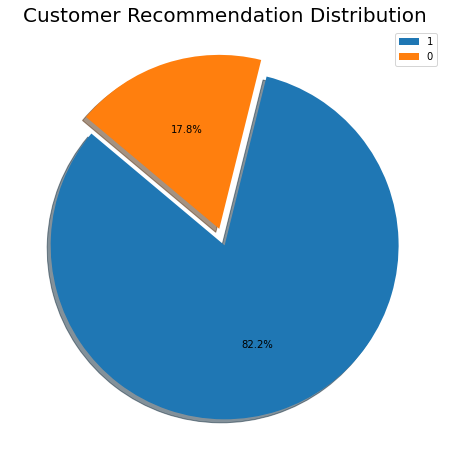

In [18]:
plt.figure(figsize=(8, 8))

explode = [0, 0.1]
plt.pie(eda_df['recommended_ind'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '0'])
plt.title('Customer Recommendation Distribution', fontsize=20)
plt.axis('off');

Just a quick note: So apparently, since the target variable ['recommended_ind'] is imbalanced, I could not rely on the accuracy score as blogs suggested( it is suggested for balanced data). So instead I will evalute based on Recall score on  results rather than Accuracy score.

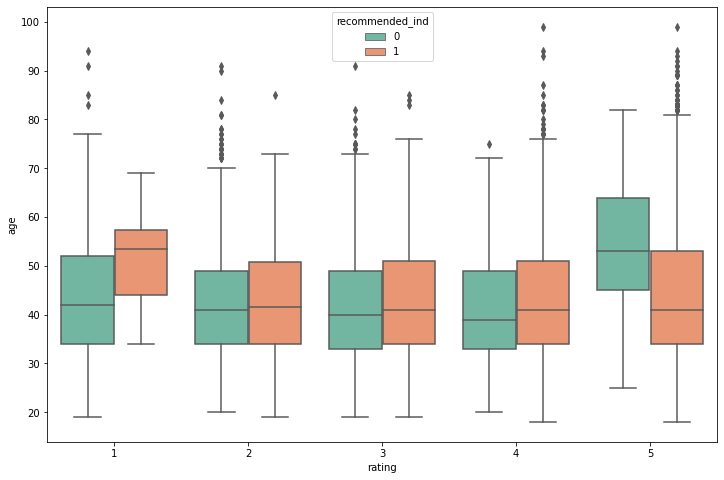

In [19]:
ax1 = sns.boxplot(x="rating", y="age", data=eda_df,hue="recommended_ind", palette="Set2")

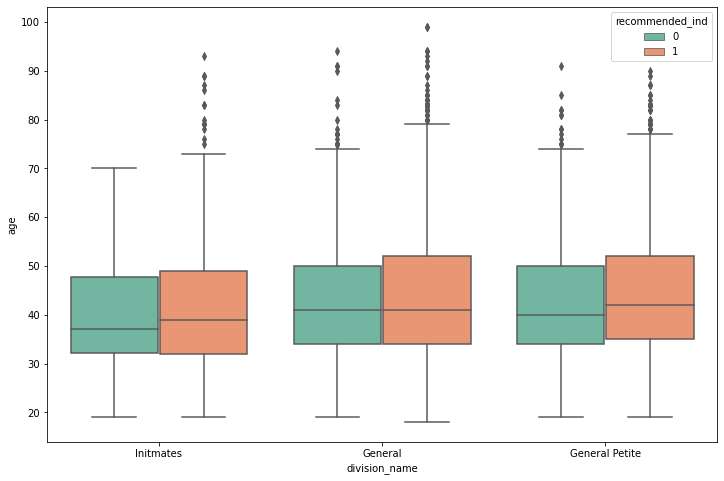

In [20]:
ax2 = sns.boxplot(x="division_name", y="age",hue="recommended_ind", data=eda_df, palette="Set2")


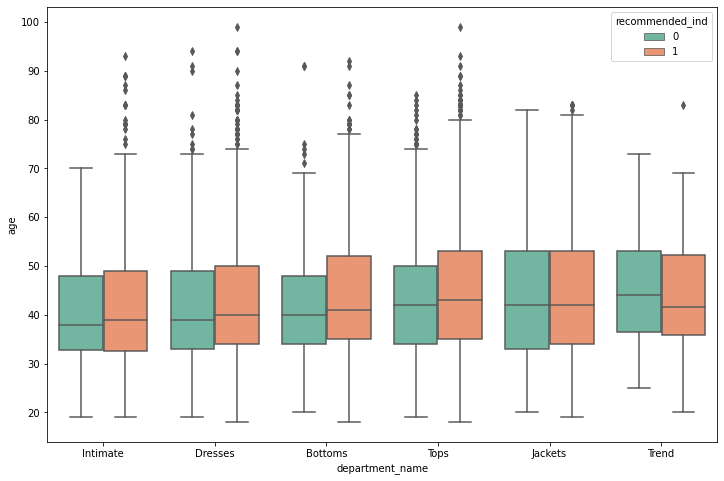

In [21]:
ax3 = sns.boxplot(x="department_name", y="age",hue="recommended_ind", data=eda_df, palette="Set2")


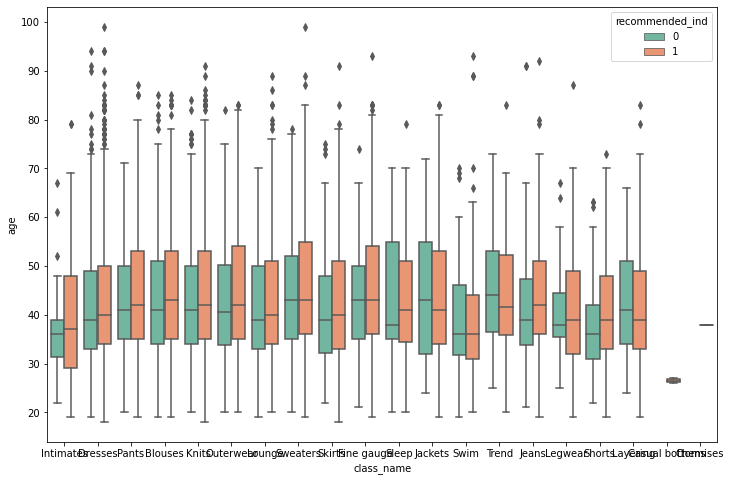

In [22]:
ax3 = sns.boxplot(x="class_name", y="age",hue="recommended_ind", data=eda_df, palette="Set2")


5.Feature Examination

In [23]:
#RATING : Positive Ordinal Integer variable for the product score given by the customer, 1 Worst, to 5 Best.
eda_df["rating"].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: rating, dtype: int64

In [24]:
investigate("rating")

column name    :  rating
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
5    13131
4     5077
3     2871
2     1565
1      842
Name: rating, dtype: int64


In [25]:
eda_df["rating"].describe().T

count   23486.00
mean        4.20
std         1.11
min         1.00
25%         4.00
50%         5.00
75%         5.00
max         5.00
Name: rating, dtype: float64

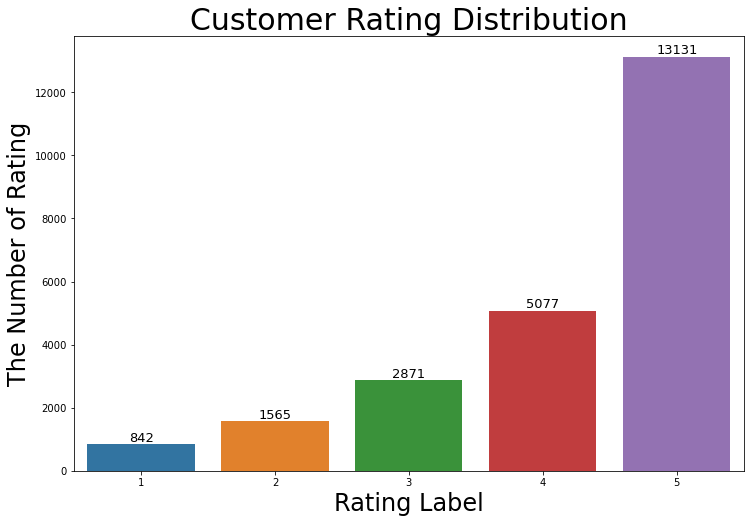

In [26]:
sns.countplot(x = eda_df.rating, data = eda_df)
plt.title('Customer Rating Distribution', fontsize=30)
plt.xlabel("Rating Label", fontsize=24)
plt.ylabel("The Number of Rating", fontsize=24)

for index,value in enumerate(eda_df.rating.value_counts().sort_values()):
     plt.text(index, value, f"{value}", ha="center", va="bottom", fontsize = 13);

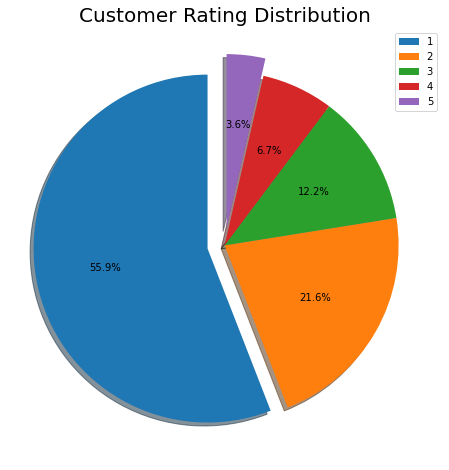

In [27]:
plt.figure(figsize=(8, 8))

explode = [0.1, 0, 0, 0, 0.1]
plt.pie(eda_df['rating'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels=['1', '2', '3', '4','5'])
plt.title('Customer Rating Distribution', fontsize=20)
plt.axis('off');

In [28]:
#AGE: Positive Integer variable of the reviewers age.
investigate("age")

column name    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  77
39    1269
35     909
36     842
34     804
38     780
37     766
41     741
33     725
46     713
42     651
32     631
48     626
44     617
40     617
43     579
31     569
47     564
53     560
45     529
29     513
49     490
56     471
52     442
28     428
26     423
30     407
50     398
54     395
51     393
57     363
27     344
60     341
62     338
25     331
55     328
59     321
58     277
66     276
64     247
23     247
24     245
63     239
61     227
65     226
67     157
22     146
68     141
69     113
20     108
21     102
70      93
71      51
74      50
72      46
83      43
73      40
19      40
75      26
77      18
78      15
79      15
82      13
76      10
80      10
85       6
84       6
91       5
89       5
81       5
18       4
87       4
94       3
90       2
86       2
93       2
99       2
92       1
Name: age, dtype: int64


In [29]:
eda_df["age"].value_counts()

39    1269
35     909
36     842
34     804
38     780
37     766
41     741
33     725
46     713
42     651
32     631
48     626
44     617
40     617
43     579
31     569
47     564
53     560
45     529
29     513
49     490
56     471
52     442
28     428
26     423
30     407
50     398
54     395
51     393
57     363
27     344
60     341
62     338
25     331
55     328
59     321
58     277
66     276
64     247
23     247
24     245
63     239
61     227
65     226
67     157
22     146
68     141
69     113
20     108
21     102
70      93
71      51
74      50
72      46
83      43
73      40
19      40
75      26
77      18
78      15
79      15
82      13
76      10
80      10
85       6
84       6
91       5
89       5
81       5
18       4
87       4
94       3
90       2
86       2
93       2
99       2
92       1
Name: age, dtype: int64

In [30]:
eda_df["age"].describe().T

count   23486.00
mean       43.20
std        12.28
min        18.00
25%        34.00
50%        41.00
75%        52.00
max        99.00
Name: age, dtype: float64

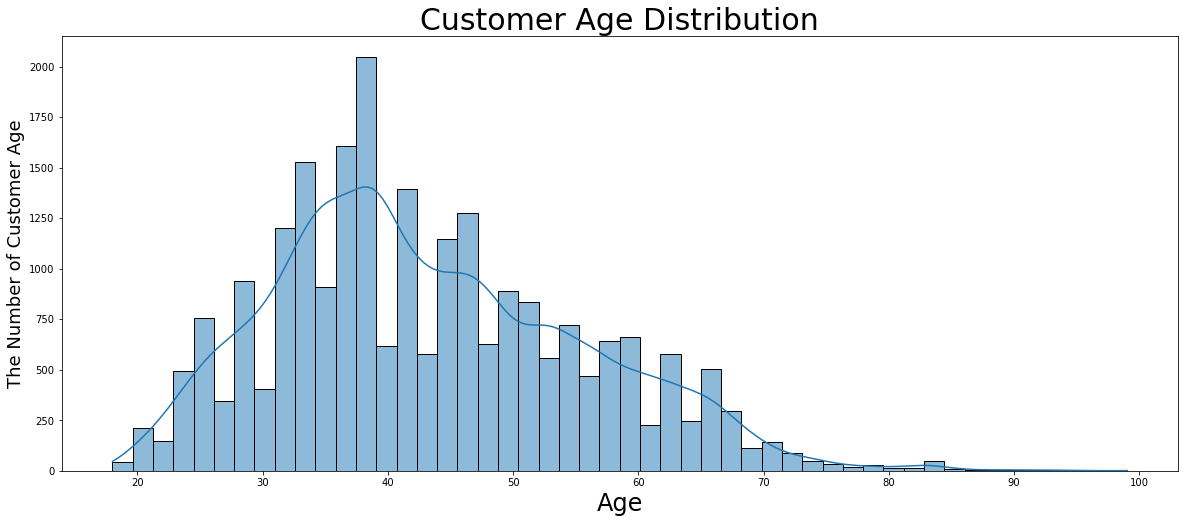

In [31]:
plt.figure(figsize = (20, 8))
plt.title('Customer Age Distribution', fontsize=30)
plt.xlabel("Age", fontsize=24)
plt.ylabel("The Number of Customer Age", fontsize=18)

sns.histplot(eda_df, x='age', kde = True, bins = 50);

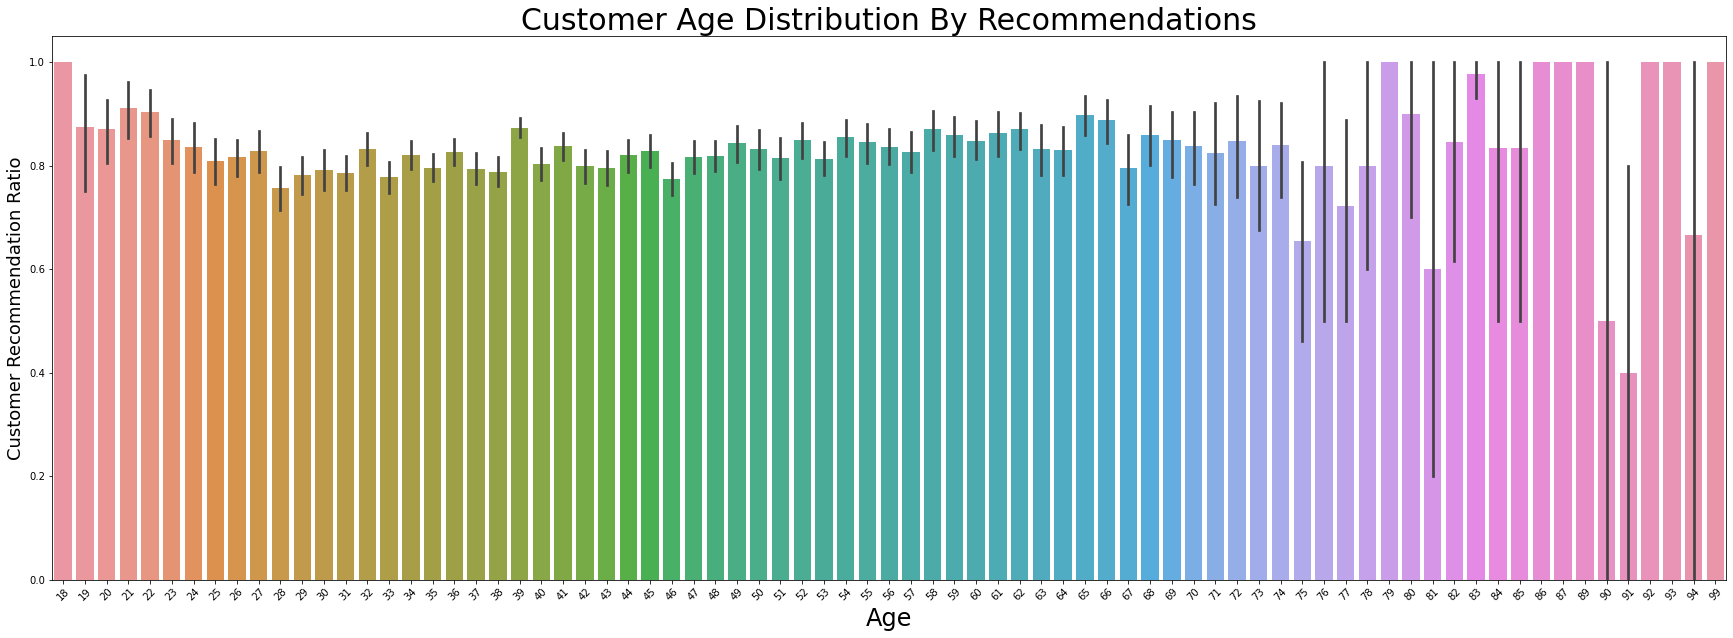

In [32]:
fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = eda_df, x = "age", y = "recommended_ind", ax=ax)

plt.title('Customer Age Distribution By Recommendations', fontsize=30)
plt.xlabel("Age", fontsize=24)
plt.ylabel("Customer Recommendation Ratio", fontsize=18)
plt.xticks(rotation = 45);

In [33]:
#this next graph is the coolest, I learned how to do it from @NAYAN SAKHIYA's heart rate disease project on kaggle.
fig = px.histogram(eda_df['age'], color=eda_df['recommended_ind'],
                   labels={'value': 'Age', 'color': 'Recommended'}, 
                   color_discrete_map={0: "magenta", 1: "MediumPurple"},
                   marginal='box')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Age and Recommendation',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

In [34]:
#POSITIVE FEEDBACK COUNT:  Positive Integer documenting the number of other customers who found this review positive.
eda_df["positive_feedback_count"].value_counts()

0      11176
1       4043
2       2193
3       1433
4        922
5        673
6        525
7        374
8        319
9        261
10       225
11       178
12       146
14       121
13       102
15        94
17        81
16        74
18        62
19        54
20        40
23        31
21        30
22        29
25        25
28        24
26        23
24        21
27        20
30        18
31        17
29        15
32        10
42         9
37         9
38         8
34         7
36         6
35         6
33         6
51         5
43         4
45         4
39         4
81         4
65         4
44         3
40         3
47         3
41         3
57         3
46         2
49         2
58         2
53         2
55         2
66         1
78         1
94         1
64         1
48         1
93         1
77         1
61         1
50         1
87         1
98         1
108        1
82         1
71         1
59         1
99         1
52         1
68         1
122        1
84         1
69         1

In [35]:
investigate("positive_feedback_count")

column name    :  positive_feedback_count
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  82
0      11176
1       4043
2       2193
3       1433
4        922
5        673
6        525
7        374
8        319
9        261
10       225
11       178
12       146
14       121
13       102
15        94
17        81
16        74
18        62
19        54
20        40
23        31
21        30
22        29
25        25
28        24
26        23
24        21
27        20
30        18
31        17
29        15
32        10
42         9
37         9
38         8
34         7
36         6
35         6
33         6
51         5
43         4
45         4
39         4
81         4
65         4
44         3
40         3
47         3
41         3
57         3
46         2
49         2
58         2
53         2
55         2
66         1
78         1
94         1
64         1
48         1
93         1
77         1
61         1
50         1
87         1
98

In [36]:
eda_df["positive_feedback_count"].describe().T

count   23486.00
mean        2.54
std         5.70
min         0.00
25%         0.00
50%         1.00
75%         3.00
max       122.00
Name: positive_feedback_count, dtype: float64

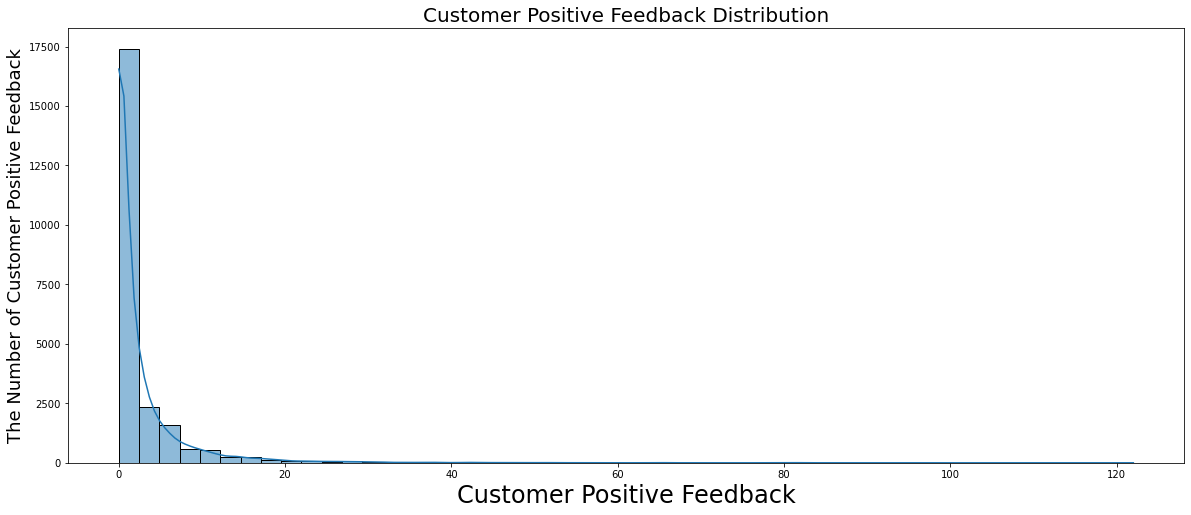

In [37]:
plt.figure(figsize = (20, 8))
plt.title('Customer Positive Feedback Distribution', fontsize=20)
plt.xlabel("Customer Positive Feedback", fontsize=24)
plt.ylabel("The Number of Customer Positive Feedback", fontsize=18)

sns.histplot(eda_df, x='positive_feedback_count', kde = True, bins = 50);

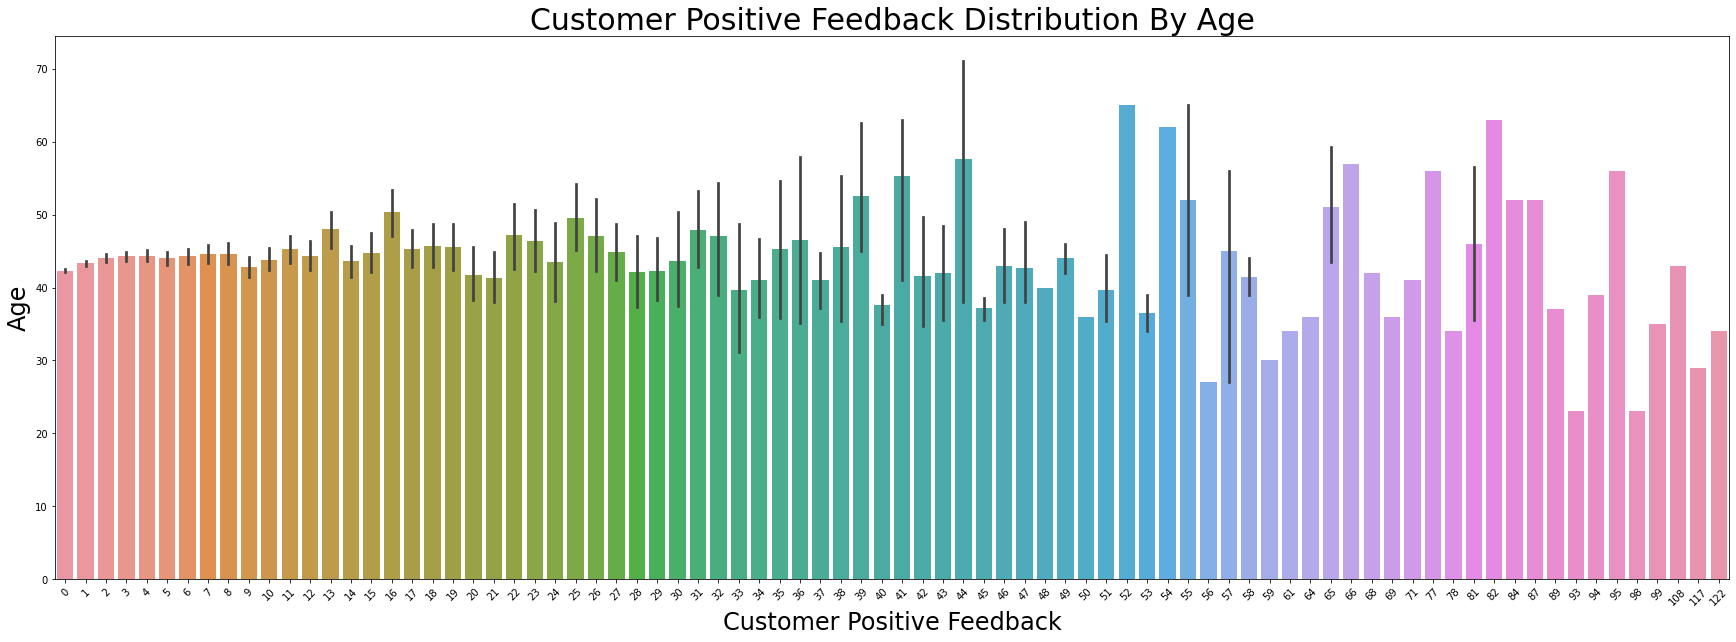

In [38]:
fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = eda_df, x = "positive_feedback_count", y = "age", ax=ax)

plt.xlabel("Customer Positive Feedback", fontsize=24)
plt.ylabel("Age", fontsize=24)

plt.title('Customer Positive Feedback Distribution By Age', fontsize=30)
plt.xticks(rotation = 45);

In [39]:
#DIVISION NAME: Categorical name of the product high level division.
eda_df["division_name"].value_counts()

General           13850
General Petite     8120
Initmates          1502
Name: division_name, dtype: int64

In [40]:
investigate("division_name")

column name    :  division_name
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  3
General           13850
General Petite     8120
Initmates          1502
NaN                  14
Name: division_name, dtype: int64


In [41]:
eda_df["division_name"].describe().T

count       23472
unique          3
top       General
freq        13850
Name: division_name, dtype: object

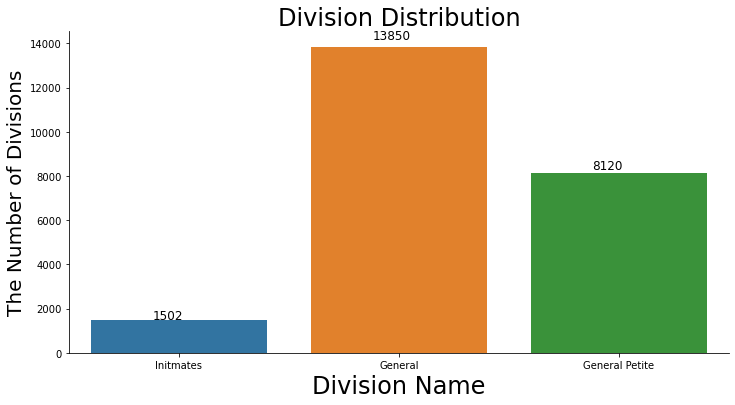

In [42]:
pl = sns.catplot( x='division_name',
             kind="count", 
             data=eda_df,
             height=5,
             aspect=2)

plt.title('Division Distribution', fontsize=24)
plt.xlabel("Division Name", fontsize=24)
plt.ylabel("The Number of Divisions", fontsize=20)

ax = pl.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.28, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

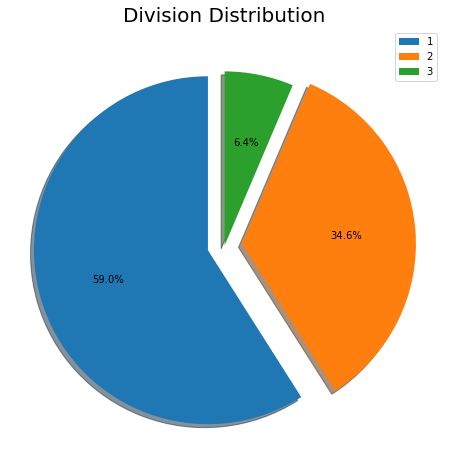

In [43]:
plt.figure(figsize=(8, 8))

explode = [0.1, 0.1, 0]
plt.pie(eda_df['division_name'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels=['1', '2', '3'])
plt.title('Division Distribution', fontsize=20)
plt.axis('off');

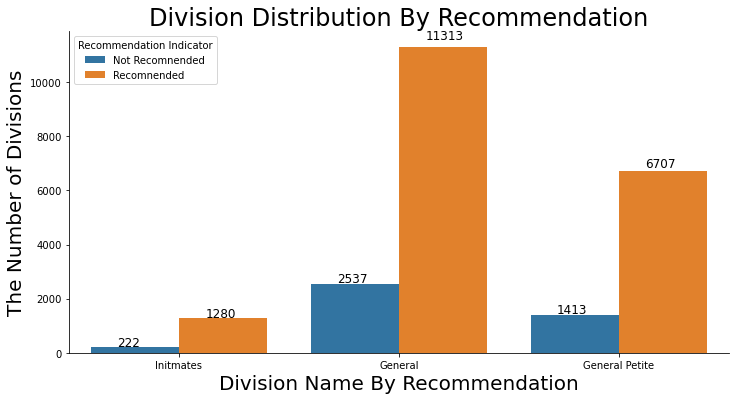

In [44]:
g = sns.catplot(data = eda_df, x ="division_name", hue = "recommended_ind", kind='count', height=5, aspect=2, legend_out=False)

plt.title('Division Distribution By Recommendation', fontsize=24)
plt.xlabel("Division Name By Recommendation", fontsize=20)
plt.ylabel("The Number of Divisions", fontsize=20)
plt.legend(title='Recommendation Indicator', loc='upper left', labels=['Not Recomnended', 'Recomnended'])

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.12, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

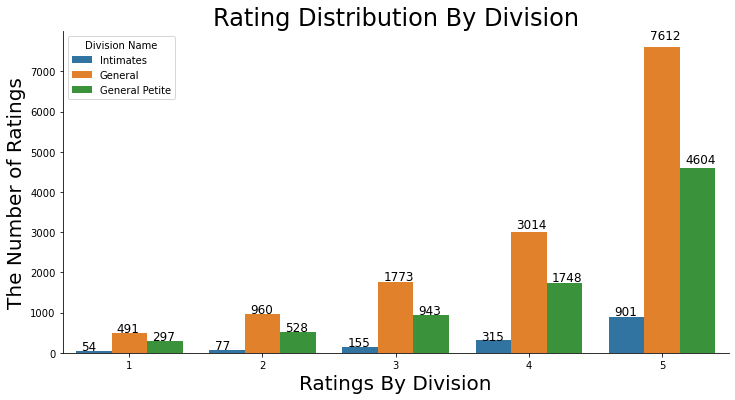

In [45]:
g = sns.catplot(data = eda_df, x ="rating", hue = "division_name", kind='count', height=5, aspect=2, legend_out=False)

plt.title('Rating Distribution By Division', fontsize=24)
plt.xlabel("Ratings By Division", fontsize=20)
plt.ylabel("The Number of Ratings", fontsize=20)
plt.legend(title='Division Name', loc='upper left', labels=['Intimates', 'General', 'General Petite'])

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.04, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

In [46]:
#DEPARTMENT NAME:Categorical variable of the product department name.
eda_df["department_name"].value_counts()

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: department_name, dtype: int64

In [47]:
investigate("department_name")

column name    :  department_name
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  6
Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
NaN            14
Name: department_name, dtype: int64


In [48]:
eda_df["department_name"].describe().T

count     23472
unique        6
top        Tops
freq      10468
Name: department_name, dtype: object

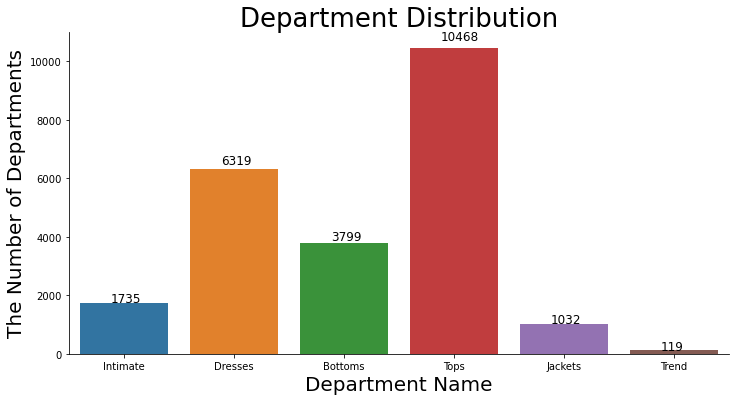

In [49]:
g = sns.catplot(data = eda_df, x ="department_name", kind='count', height=5, aspect=2)

plt.title('Department Distribution', fontsize=26)
plt.xlabel("Department Name", fontsize=20)
plt.ylabel("The Number of Departments", fontsize=20)

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.28, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

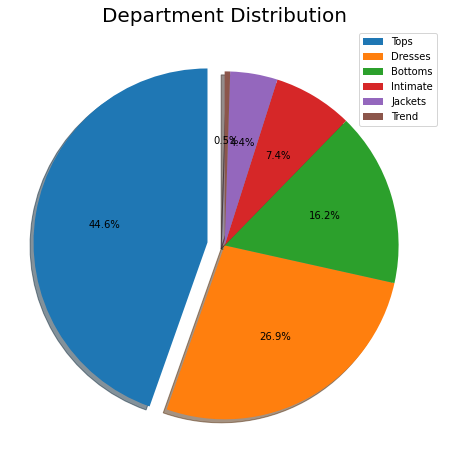

In [50]:
plt.figure(figsize=(8, 8))

explode = [0.1, 0, 0, 0, 0, 0]
plt.pie(eda_df['department_name'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels=['Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend'])
plt.title('Department Distribution', fontsize=20)
plt.axis('off');

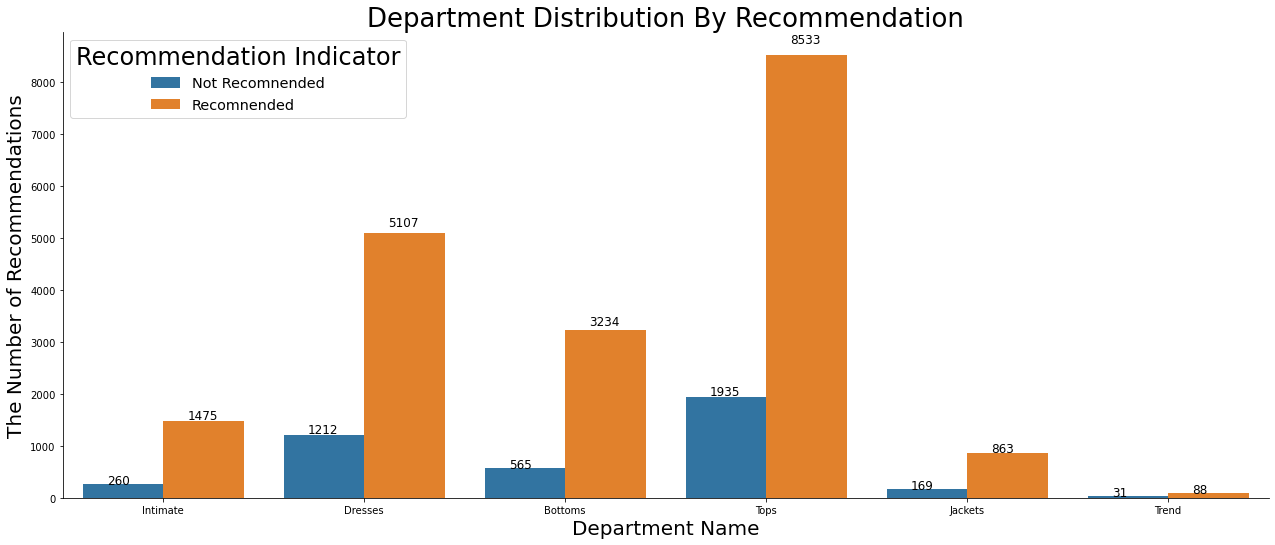

In [51]:
g = sns.catplot(data = eda_df, x ="department_name", hue = "recommended_ind", kind='count', height=7, aspect=2.5, legend_out=False)

plt.title('Department Distribution By Recommendation', fontsize=26)
plt.xlabel("Department Name", fontsize=20)
plt.ylabel("The Number of Recommendations", fontsize=20)
plt.legend(title='Recommendation Indicator', loc='upper left', labels=['Not Recomnended', 'Recomnended'], fontsize='x-large', title_fontsize='24')

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.12, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

<Figure size 1080x576 with 0 Axes>

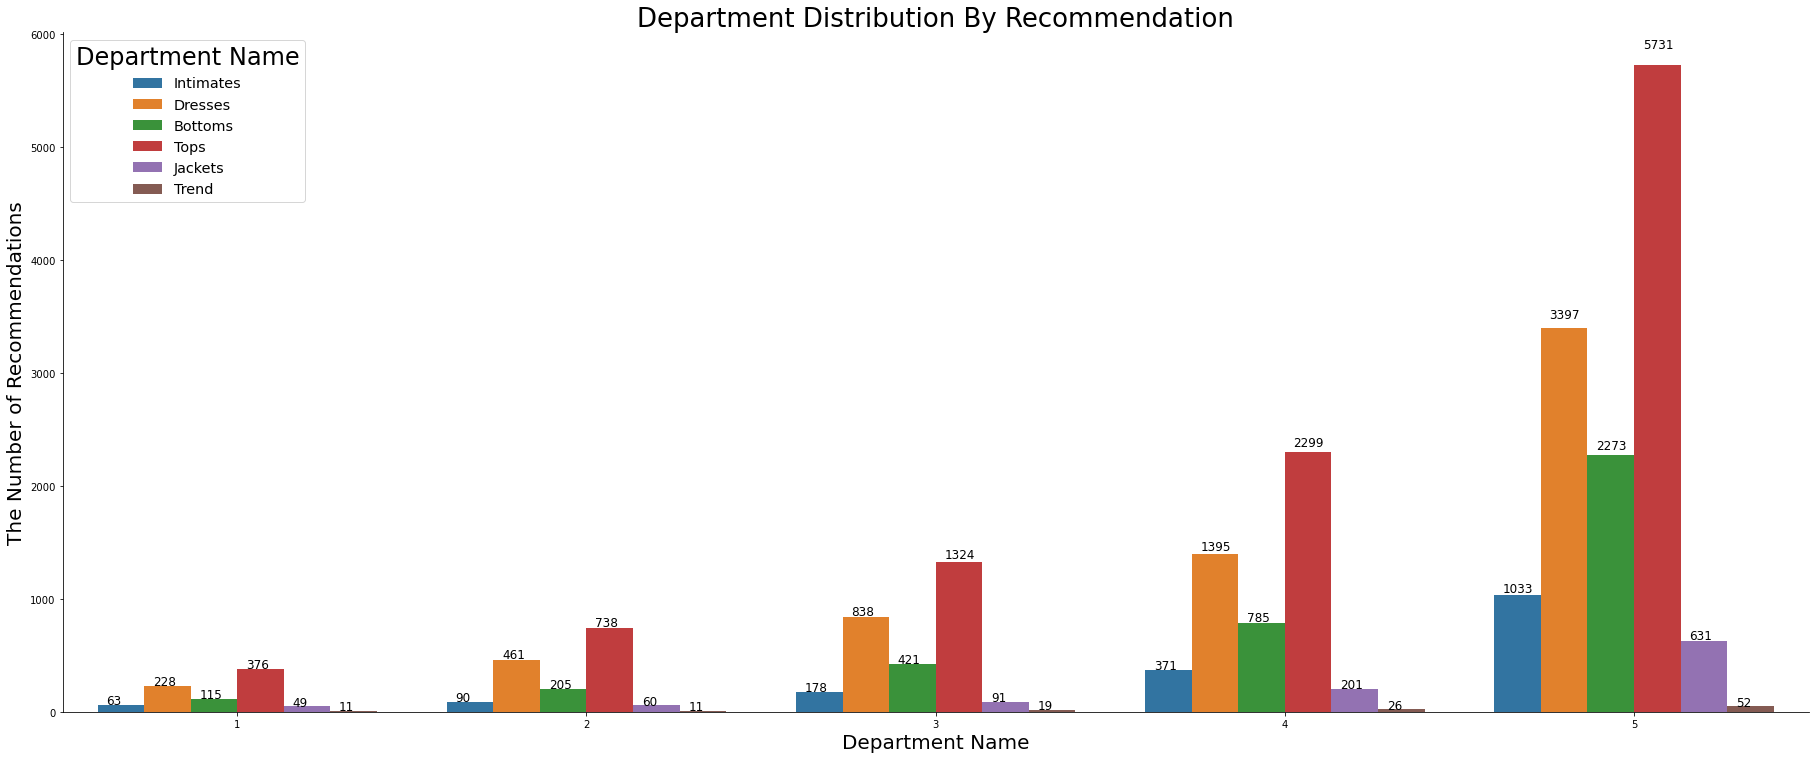

In [52]:
g = sns.catplot(data = eda_df, x ="rating", hue = "department_name", kind='count', height=10, aspect=2.5, legend_out=False)

plt.title('Department Distribution By Recommendation', fontsize=26)
plt.xlabel("Department Name", fontsize=20)
plt.ylabel("The Number of Recommendations", fontsize=20)
plt.legend(title='Department Name', loc='upper left', labels=['Intimates', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend'], fontsize='x-large', title_fontsize='24')
plt.figure(figsize=(15, 8))

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.025, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

In [53]:
#CLASS NAME:Categorical variable of the product class name.
eda_df["class_name"].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: class_name, dtype: int64

In [54]:
investigate("class_name")

column name    :  class_name
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  20
Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
NaN                 14
Casual bottoms       2
Chemises             1
Name: class_name, dtype: int64


In [55]:
eda_df["class_name"].describe().T

count       23472
unique         20
top       Dresses
freq         6319
Name: class_name, dtype: object

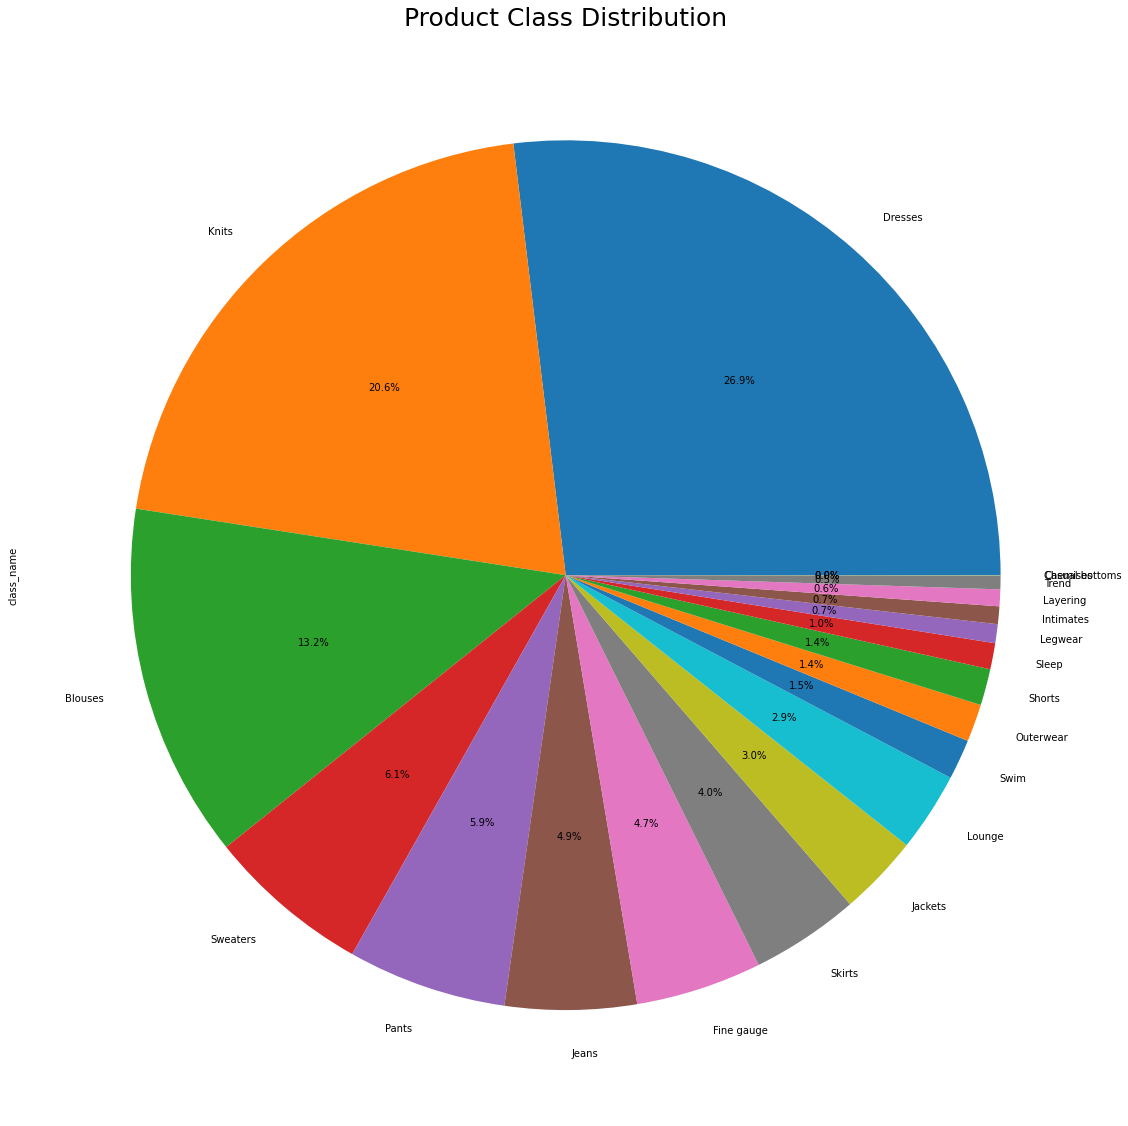

In [56]:
plt.title('Product Class Distribution', fontsize=25)
eda_df["class_name"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(20, 20));

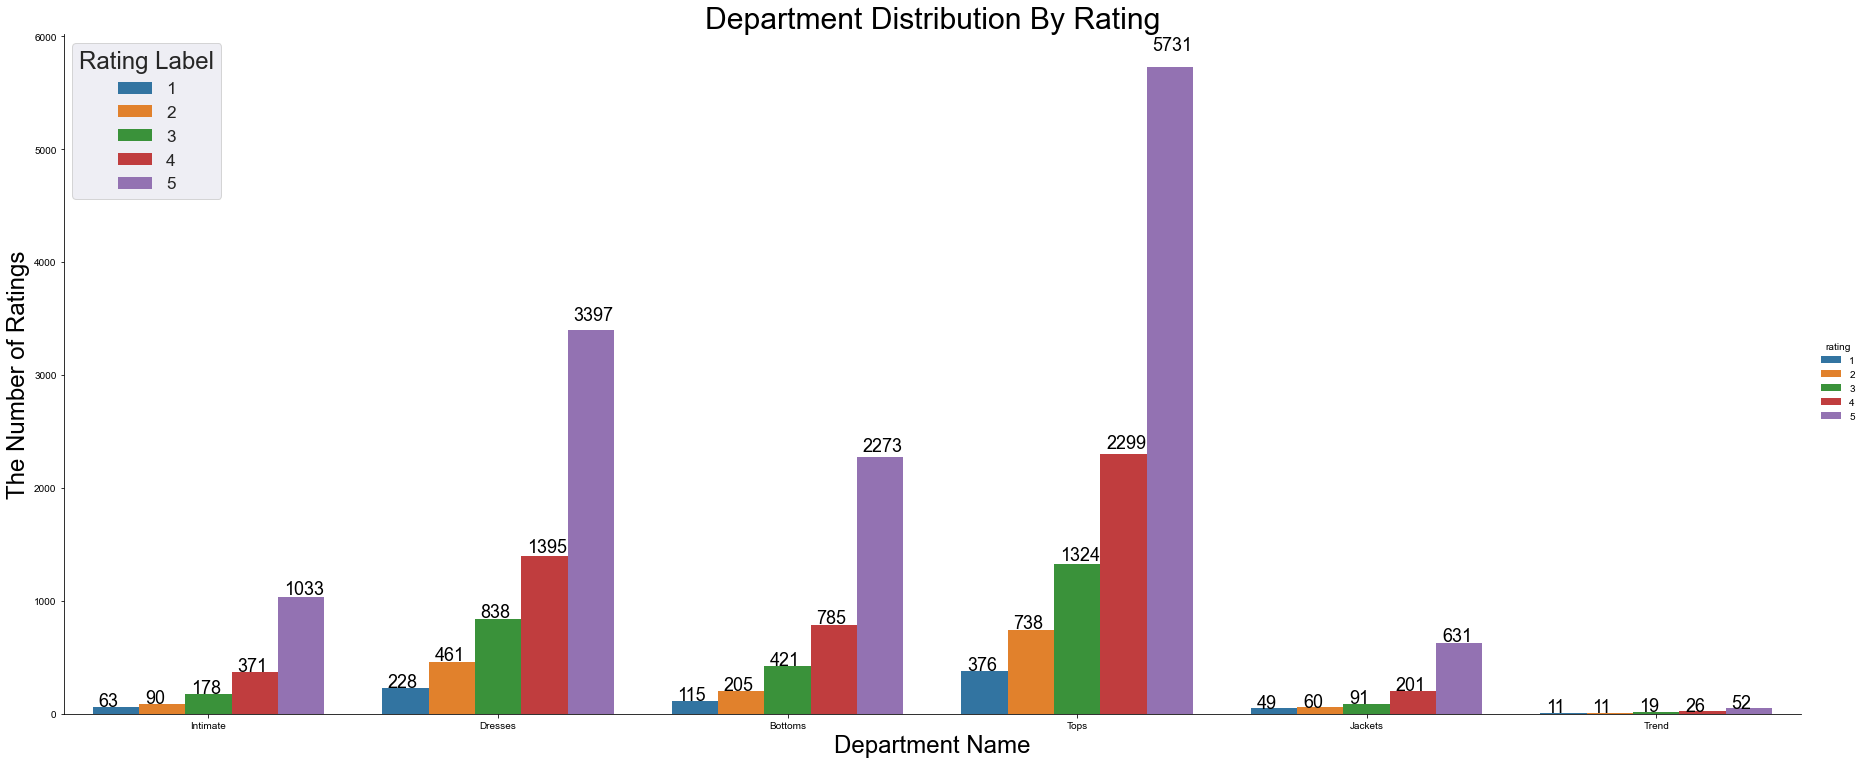

In [57]:
g = sns.catplot(data = eda_df, x ="department_name", hue = "rating", kind='count', height=10, aspect=2.5)

sns.set(rc = {'figure.figsize':(30, 12)})
plt.title('Department Distribution By Rating', fontsize=30)
plt.xlabel("Department Name", fontsize=24)
plt.ylabel("The Number of Ratings", fontsize=24)
plt.legend(title='Rating Label', loc='upper left', labels=['1', '2', '3', '4', '5'], fontsize='x-large', title_fontsize='24')

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.02, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large', fontsize = 18)

plt.show()

In [58]:
#Another recently learned figure treemap. This I learned from stackoverflow, so fascinating almost looks like a BI tool graph
word_Frequency = eda_df['review_text'].str.split(expand=True).stack().value_counts()
word_Frequency_top200 = word_Frequency[:200]

fig = px.treemap(word_Frequency_top200, path=[word_Frequency_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (Before Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [59]:
#categorical and numerical sets for the examination of crosstab information.

In [60]:
categorical_df = eda_df[['division_name', 'department_name', 'class_name', "recommended_ind"]]
categorical_df["recommended_ind"] = categorical_df["recommended_ind"].apply(lambda x: "Recommended" if x>=1 else "Not Recommended")
categorical_df.rename({'division_name': 'Division Name', 'department_name': 'Department Name', 'class_name': 'Class Name', 'recommended_ind': 'Recommendation Indicator'}, axis=1, inplace=True)
categorical_df

Division Name Department Name Class Name Recommendation Indicator
0           Initmates        Intimate  Intimates              Recommended
1             General         Dresses    Dresses              Recommended
2             General         Dresses    Dresses          Not Recommended
3      General Petite         Bottoms      Pants              Recommended
4             General            Tops    Blouses              Recommended
...               ...             ...        ...                      ...
23481  General Petite         Dresses    Dresses              Recommended
23482  General Petite            Tops      Knits              Recommended
23483  General Petite         Dresses    Dresses          Not Recommended
23484         General         Dresses    Dresses              Recommended
23485  General Petite         Dresses    Dresses              Recommended

[23486 rows x 4 columns]

In [61]:
numerical_df = eda_df[['age', 'rating', 'positive_feedback_count', 'recommended_ind']]
numerical_df["recommended_ind"] = numerical_df["recommended_ind"].apply(lambda x: "Recommended" if x>=1 else "Not Recommended")
numerical_df.rename({'age': 'Age', 'rating': 'Rating', 'positive_feedback_count': 'Positive Feedback', 'recommended_ind': 'Recommendation Indicator'}, axis=1, inplace=True)
numerical_df

Age  Rating  Positive Feedback Recommendation Indicator
0       33       4                  0              Recommended
1       34       5                  4              Recommended
2       60       3                  0          Not Recommended
3       50       5                  0              Recommended
4       47       5                  6              Recommended
...    ...     ...                ...                      ...
23481   34       5                  0              Recommended
23482   48       3                  0              Recommended
23483   31       3                  1          Not Recommended
23484   28       3                  2              Recommended
23485   52       5                 22              Recommended

[23486 rows x 4 columns]

In [62]:
for i, col in enumerate(categorical_df.columns):
    xtab = pd.crosstab(categorical_df[col], categorical_df["Recommendation Indicator"], normalize=True)
    print(colored('-'*55, 'blue', attrs=['bold']), sep='')
    print(xtab*100)

-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Division Name                                         
General                             10.81        48.20
General Petite                       6.02        28.57
Initmates                            0.95         5.45
-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Department Name                                       
Bottoms                              2.41        13.78
Dresses                              5.16        21.76
Intimate                             1.11         6.28
Jackets                              0.72         3.68
Tops                                 8.24        36.35
Trend                                0.13         0.37
-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Class Name                                            
Blouses

In [63]:
for i, col in enumerate(numerical_df.columns):
    xtab = pd.crosstab(numerical_df[col], numerical_df["Recommendation Indicator"], normalize=True)
    print(colored('-'*55, 'blue', attrs=['bold']), sep='')
    print(xtab*100)

-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Age                                                   
18                                   0.00         0.02
19                                   0.02         0.15
20                                   0.06         0.40
21                                   0.04         0.40
22                                   0.06         0.56
23                                   0.16         0.89
24                                   0.17         0.87
25                                   0.27         1.14
26                                   0.33         1.47
27                                   0.25         1.21
28                                   0.44         1.38
29                                   0.48         1.71
30                                   0.36         1.37
31                                   0.52         1.90
32                                   0.45         2.24
33       

6.Feature Selection and Dataset Manipulation

In [64]:
eda_df.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

In [65]:
#For this analysis, I will be using only the recommended_ind and review_test columns, so I am dropping the other unnecessary columns.

In [66]:
eda_df.drop(['clothing_id', 'age', 'title', 'rating',
       'positive_feedback_count', 'division_name',
       'department_name', 'class_name'], axis=1, inplace=True)

In [67]:
eda_df.head(5)

review_text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   
3                                                                             I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4         This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   

   recommended_ind  
0                1  
1                1  
2                0  
3                1  
4                1

7.Data Wrangling

In [68]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      22641 non-null  object
 1   recommended_ind  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 275.3+ KB


In [69]:
eda_df['review_text'].isnull().value_counts()

False    22641
True       845
Name: review_text, dtype: int64

In [70]:
eda_df['recommended_ind'].isnull().value_counts()

False    23486
Name: recommended_ind, dtype: int64

In [71]:
#Since the number of null values are relatively small, I am dropping them  and creating clean_df
clean_df = eda_df.dropna()

In [72]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      22641 non-null  object
 1   recommended_ind  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 442.2+ KB


In [73]:
clean_df['review_text'].isnull().value_counts()

False    22641
Name: review_text, dtype: int64

In [74]:
clean_df['recommended_ind'].isnull().value_counts()

False    22641
Name: recommended_ind, dtype: int64

In [75]:
missing_values(clean_df)

Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []

8.Text Mining

In [76]:
#First I need to do some text preprocessing since text is unstructured data. I chose tokenization method, and learned the code from  an NLTK library tutorial

In [77]:
def data_preprocess(data):
    
    #1. Removing Punctuations
    # \w typically matches [A-Za-z0-9_]
    text = re.sub('[^\w\s]','', data)
         
    #2. Tokenizing the text
    text_tokens = word_tokenize(text.lower()) 
    
    #3. Removing numbers
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #5. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [78]:
stop_words = stopwords.words('english')

In [79]:
text = data_preprocess(str(clean_df["review_text"]))
text

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact co love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt happy snag dress great price easy slip flattering cut color combo reminds maternity clothes soft stretchy shiny material cut flattering drape nicely found one button close front looked awkward nice long sleevesnnot bu fit well top see never would worked im glad able try store didnt order online different fabric would bought dress wedding summer cute unfortunately fit isnt perfect medium fit waist perfectly way long big bust sh dress lovely platinum feminine fit perfectly easy wear comfy highly recommend name length d

In [80]:
clean_df["review_text"] = clean_df["review_text"].apply(data_preprocess)
clean_df["review_text"].head()

0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

In [81]:
" ".join(clean_df["review_text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'outrageously',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'complimen

In [82]:
word_counts = pd.Series(" ".join(clean_df["review_text"]).split()).value_counts()
word_counts

dress       11319
fit         10091
size         9349
love         8968
top          8256
            ...  
allergy         1
risking         1
vintagey        1
notably         1
oclock          1
Length: 16758, dtype: int64

In [83]:
outlier_words = word_counts[word_counts <= 2]
outlier_words

rocked           2
didt             2
blight           2
designpattern    2
heavyhot         2
                ..
allergy          1
risking          1
vintagey         1
notably          1
oclock           1
Length: 10935, dtype: int64

In [84]:
outlier_words.value_counts()

1    9058
2    1877
dtype: int64

In [85]:
len(outlier_words)

10935

In [86]:
clean_df["review_text"] = clean_df["review_text"].apply(lambda x: " ".join([i for i in x.split() if i not in outlier_words.index]))
clean_df["review_text"].head()

0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight l...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

In [87]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      22641 non-null  object
 1   recommended_ind  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 442.2+ KB


9.Collecting Positive and Negative words seperately

In [88]:
" ".join(clean_df["review_text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'f

In [89]:
negative_words = " ".join(clean_df[clean_df["recommended_ind"] == 0].review_text).split()
negative_words 

['high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'tracy',
 'reese',
 'dress',
 'one',
 'petite',
 'foot',
 'tall',
 'usually',
 'wear',
 'brand',
 'dress',
 'pretty',
 'package',
 'lot',
 'dress',
 'skirt',
 'long',
 'full',
 'overwhelmed',
 'small',
 'frame',
 'stranger',
 'alteration',
 'shortening',
 'skirt',
 'would',
 'take',
 'away',
 'embellishment',
 'garment',
 'love',
 'color',
 'idea',
 'style',
 'work',
 'returned',
 'dress',
 'dress',
 'run',
 'small',
 'esp',
 'zipper',
 'area',
 'run',
 'ordered',
 'sp',
 'typically',
 'fit',
 'tight',
 'mat

In [90]:
positive_words =" ".join(clean_df[clean_df["recommended_ind"] == 1].review_text).split()
positive_words

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'flattering',
 'due',
 'adjustable',
 'front',
 'tie',
 'perfect',
 'length',
 'wear',
 'legging',
 'sleeveless',
 'pair',
 'well',
 'cardigan',
 'love',
 'shirt',
 'basket',
 'hte',
 'last',
 'see',
 'would',
 'look',
 'like',
 'person',
 'store',
 'pick',
 'went',
 'teh',
 'color',
 'pale',
 'hte',
 'color',
 'really',
 'gorgeous',
 'turn',
 'trying',
 'little',
 'baggy',
 'hte',
 'x',
 'hte',
 'size',
 'bummer',
 'petite',
 'decided',
 'though',
 'said',
 'everything',
 '

10.WordCloud

In [91]:
#to represent the most common words

In [92]:
review_text = clean_df["review_text"]

In [93]:
all_words = " ".join(review_text)

In [94]:
all_words[:100]

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc ne'

In [95]:
#'supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

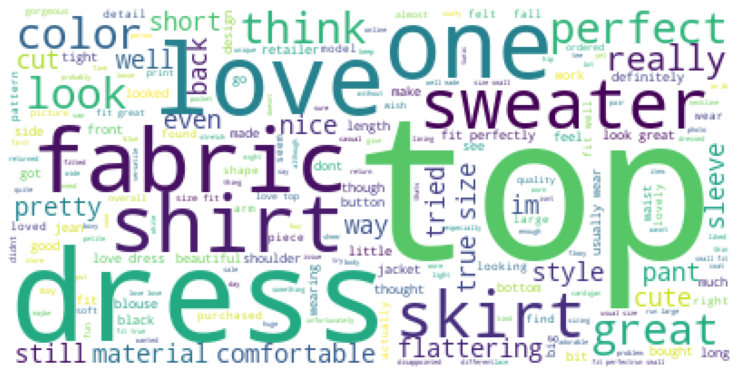

In [96]:
wordcloud = WordCloud(background_color="white", max_words =250).generate(all_words)

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

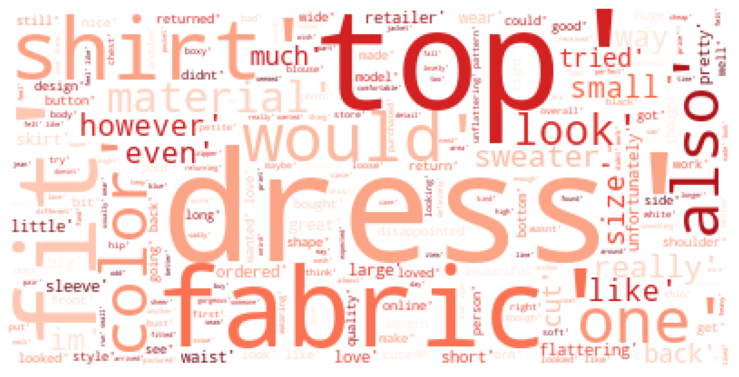

In [97]:
wordcloud_neg = WordCloud(background_color="white", max_words =250, colormap='Reds').generate(str(negative_words))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

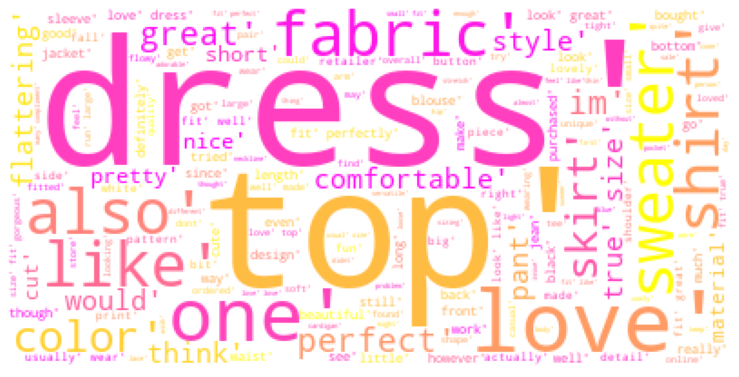

In [98]:
wordcloud_pos = WordCloud(background_color="white", max_words =250, colormap='spring_r').generate(str(positive_words))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()

11.Train/Test Split

In [99]:
#converting text files into numerical feature vectors to run ml models later. I will  use bag of words model for this analysis.

In [100]:
clean_df.head()

review_text  \
0                                                                                                                                                              absolutely wonderful silky sexy comfortable   
1                     love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite   
2  high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight l...   
3                                                                                                                 love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment   
4                                                                                           shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt   

   recommended_ind  
0                1  
1                1  
2                0  
3                1  
4                1

In [101]:
X = clean_df["review_text"]
y= clean_df["recommended_ind"]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)

12.Vectorization

In [103]:
#count vectorizer
vectorizer = CountVectorizer()

X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [104]:
type(X_train_count)

scipy.sparse.csr.csr_matrix

In [105]:
X_train_count.astype(np.uint8).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [106]:
vectorizer.get_feature_names()

['aa',
 'ab',
 'abby',
 'abdomen',
 'ability',
 'able',
 'abo',
 'abovetheknee',
 'absolute',
 'absolutely',
 'absolutley',
 'abstract',
 'absurd',
 'abt',
 'abundance',
 'ac',
 'accent',
 'accented',
 'accentuate',
 'accentuated',
 'accentuates',
 'accentuating',
 'accept',
 'acceptable',
 'access',
 'accessorize',
 'accessorized',
 'accessorizing',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accommodate',
 'accommodates',
 'accommodating',
 'accomodate',
 'according',
 'accordingly',
 'account',
 'accurate',
 'accurately',
 'achieve',
 'across',
 'acrylic',
 'act',
 'action',
 'active',
 'activewear',
 'activity',
 'actual',
 'actuality',
 'actually',
 'ad',
 'ada',
 'add',
 'added',
 'addicted',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adequate',
 'adequately',
 'adjust',
 'adjustable',
 'adjusted',
 'adjusting',
 'adjustment',
 'admire',
 'admired',
 'admiring',
 'admit',
 'admittedly',
 'adn',
 'ador',
 'adorable',
 'adore',
 'adored',

In [107]:
pd.DataFrame(X_train_count.astype(np.uint8).toarray(), columns = vectorizer.get_feature_names())

aa  ab  abby  abdomen  ability  able  abo  abovetheknee  absolute  \
0       0   0     0        0        0     0    0             0         0   
1       0   0     0        0        0     0    0             0         0   
2       0   0     0        0        0     0    0             0         0   
3       0   0     0        0        0     0    0             0         0   
4       0   0     0        0        0     0    0             0         0   
...    ..  ..   ...      ...      ...   ...  ...           ...       ...   
15843   0   0     0        0        0     0    0             0         0   
15844   0   0     0        0        0     0    0             0         0   
15845   0   0     0        0        0     0    0             0         0   
15846   0   0     0        0        0     0    0             0         0   
15847   0   0     0        0        0     0    0             0         0   

       absolutely  absolutley  abstract  absurd  abt  abundance  ac  accent  \
0               0           0         0       0    0          0   0       0   
1               0           0         0       0    0          0   0       0   
2               0           0         0       0    0          0   0       0   
3               0           0         0       0    0          0   0       0   
4               0           0         0       0    0          0   0       0   
...           ...         ...       ...     ...  ...        ...  ..     ...   
15843           0           0         0       0    0          0   0       0   
15844           0           0         0       0    0          0   0       0   
15845           0           0         0       0    0          0   0       0   
15846           0           0         0       0    0          0   0       0   
15847           0           0         0       0    0          0   0       0   

       accented  accentuate  accentuated  accentuates  accentuating  accept  \
0             0           0            0            0             0       0   
1             0           0            0            0             0       0   
2             0           0            0            0             0       0   
3             0           0            0            0             0       0   
4             0           0            0            0             0       0   
...         ...         ...          ...          ...           ...     ...   
15843         0           0            0            0             0       0   
15844         0           0            0            0             0       0   
15845         0           0            0            0             0       0   
15846         0           0            0            0             0       0   
15847         0           0            0            0             0       0   

       acceptable  access  accessorize  accessorized  accessorizing  \
0               0       0            0             0              0   
1               0       0            0             0              0   
2               0       0            0             0              0   
3               0       0            0             0              0   
4               0       0            0             0              0   
...           ...     ...          ...           ...            ...   
15843           0       0            0             0              0   
15844           0       0            0             0              0   
15845           0       0            0             0              0   
15846           0       0            0             0              0   
15847           0       0            0             0              0   

       accessory  accident  accidental  accidentally  accommodate  \
0              0         0           0             0            0   
1              0         0           0             0            0   
2              0         0           0             0            0   
3              0         0           0             0            0  

In [108]:
#tfidf vectorizer
tf_idf_vectorizer = TfidfVectorizer()

X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [109]:
X_train_tf_idf.astype(np.uint8).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [110]:
pd.DataFrame(X_train_tf_idf.astype(np.uint8).toarray(), columns = tf_idf_vectorizer.get_feature_names())

aa  ab  abby  abdomen  ability  able  abo  abovetheknee  absolute  \
0       0   0     0        0        0     0    0             0         0   
1       0   0     0        0        0     0    0             0         0   
2       0   0     0        0        0     0    0             0         0   
3       0   0     0        0        0     0    0             0         0   
4       0   0     0        0        0     0    0             0         0   
...    ..  ..   ...      ...      ...   ...  ...           ...       ...   
15843   0   0     0        0        0     0    0             0         0   
15844   0   0     0        0        0     0    0             0         0   
15845   0   0     0        0        0     0    0             0         0   
15846   0   0     0        0        0     0    0             0         0   
15847   0   0     0        0        0     0    0             0         0   

       absolutely  absolutley  abstract  absurd  abt  abundance  ac  accent  \
0               0           0         0       0    0          0   0       0   
1               0           0         0       0    0          0   0       0   
2               0           0         0       0    0          0   0       0   
3               0           0         0       0    0          0   0       0   
4               0           0         0       0    0          0   0       0   
...           ...         ...       ...     ...  ...        ...  ..     ...   
15843           0           0         0       0    0          0   0       0   
15844           0           0         0       0    0          0   0       0   
15845           0           0         0       0    0          0   0       0   
15846           0           0         0       0    0          0   0       0   
15847           0           0         0       0    0          0   0       0   

       accented  accentuate  accentuated  accentuates  accentuating  accept  \
0             0           0            0            0             0       0   
1             0           0            0            0             0       0   
2             0           0            0            0             0       0   
3             0           0            0            0             0       0   
4             0           0            0            0             0       0   
...         ...         ...          ...          ...           ...     ...   
15843         0           0            0            0             0       0   
15844         0           0            0            0             0       0   
15845         0           0            0            0             0       0   
15846         0           0            0            0             0       0   
15847         0           0            0            0             0       0   

       acceptable  access  accessorize  accessorized  accessorizing  \
0               0       0            0             0              0   
1               0       0            0             0              0   
2               0       0            0             0              0   
3               0       0            0             0              0   
4               0       0            0             0              0   
...           ...     ...          ...           ...            ...   
15843           0       0            0             0              0   
15844           0       0            0             0              0   
15845           0       0            0             0              0   
15846           0       0            0             0              0   
15847           0       0            0             0              0   

       accessory  accident  accidental  accidentally  accommodate  \
0              0         0           0             0            0   
1              0         0           0             0            0   
2              0         0           0             0            0   
3              0         0           0             0            0  

13.ML MODELING

#For machine learning modeling, I will be testing 4 different models with both of the vectorization methods. 
1.Logistic regression, 
2.Naive Bayes
3.SVM (Support Vector Machine)
4.Random Forest

In [111]:
#custom model comparison function
def model_evaluation(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("Test_Set")
    print(classification_report(y_test, y_pred))
    print("Train_Set")
    print(classification_report(y_train, y_pred_train))
    fig, ax = plt.subplots(figsize=(8, 8))
    
    plot_confusion_matrix(model, X_test, y_test, ax=ax)

13.1 - Logistic Regression

13.1.a Logistic Regression With Count Vectorizer 

In [112]:
logReg = LogisticRegression(C =0.6, max_iter=1000, class_weight= "balanced", random_state=101)
logReg.fit(X_train_count,y_train)

LogisticRegression(C=0.6, class_weight='balanced', max_iter=1000,
                   random_state=101)

LOG MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.62      0.80      0.69      1230
           1       0.95      0.89      0.92      5563

    accuracy                           0.87      6793
   macro avg       0.78      0.84      0.81      6793
weighted avg       0.89      0.87      0.88      6793

Train_Set
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      2871
           1       0.99      0.92      0.95     12977

    accuracy                           0.93     15848
   macro avg       0.86      0.94      0.89     15848
weighted avg       0.94      0.93      0.93     15848



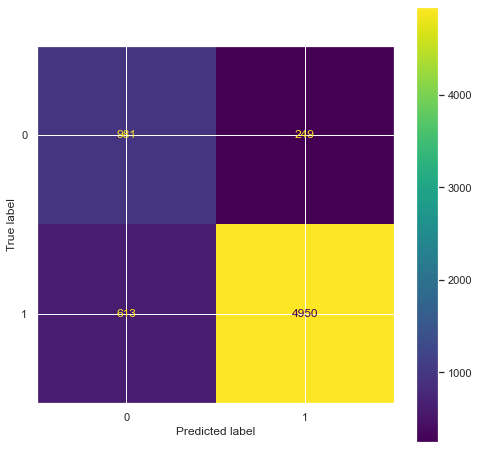

In [113]:
print("LOG MODEL")

model_evaluation(logReg, X_train_count, X_test_count)

13.1.b Logistic Regression With TF-IDF Vectorizer

In [114]:
logReg2 = LogisticRegression(C=0.1, max_iter=1000, random_state=101, class_weight="balanced")

logReg2.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=101)

LOG MODEL 2
Test_Set
              precision    recall  f1-score   support

           0       0.55      0.85      0.67      1230
           1       0.96      0.85      0.90      5563

    accuracy                           0.85      6793
   macro avg       0.76      0.85      0.79      6793
weighted avg       0.89      0.85      0.86      6793

Train_Set
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      2871
           1       0.97      0.85      0.91     12977

    accuracy                           0.86     15848
   macro avg       0.77      0.87      0.80     15848
weighted avg       0.90      0.86      0.87     15848



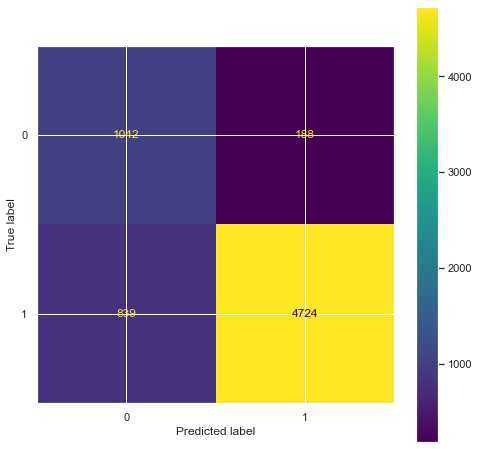

In [115]:
print("LOG MODEL 2")

model_evaluation(logReg2, X_train_tf_idf, X_test_tf_idf)

13.2 - Naive Bayes

13.2.a Naive Bayes With Count Vectorizer

In [116]:
nb = MultinomialNB()
nb.fit(X_train_count, y_train)

MultinomialNB()

NB MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.66      0.73      0.70      1230
           1       0.94      0.92      0.93      5563

    accuracy                           0.88      6793
   macro avg       0.80      0.83      0.81      6793
weighted avg       0.89      0.88      0.89      6793

Train_Set
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2871
           1       0.96      0.93      0.94     12977

    accuracy                           0.91     15848
   macro avg       0.83      0.87      0.85     15848
weighted avg       0.91      0.91      0.91     15848



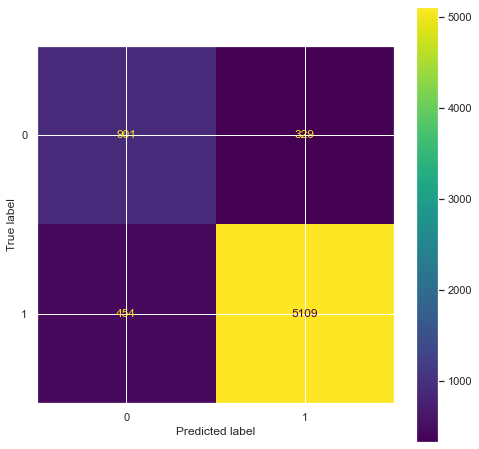

In [117]:
print("NB MODEL")

model_evaluation(nb, X_train_count, X_test_count)

13.2.b Naive Bayes With TF-IDF Vectorizer

In [118]:
nb2 = MultinomialNB()
nb2.fit(X_train_tf_idf, y_train)

MultinomialNB()

NB MODEL 2
Test_Set
              precision    recall  f1-score   support

           0       0.91      0.14      0.24      1230
           1       0.84      1.00      0.91      5563

    accuracy                           0.84      6793
   macro avg       0.87      0.57      0.58      6793
weighted avg       0.85      0.84      0.79      6793

Train_Set
              precision    recall  f1-score   support

           0       0.95      0.20      0.33      2871
           1       0.85      1.00      0.92     12977

    accuracy                           0.85     15848
   macro avg       0.90      0.60      0.63     15848
weighted avg       0.87      0.85      0.81     15848



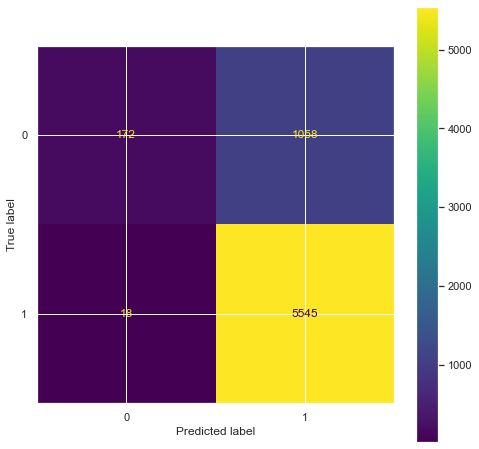

In [119]:
print("NB MODEL 2")
model_evaluation(nb2, X_train_tf_idf, X_test_tf_idf)

13.3 - SVM

13.3.a Support Vector Machine (SVM) With Count Vectorizer

In [120]:
svc = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

SVC MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      1230
           1       0.96      0.88      0.92      5563

    accuracy                           0.87      6793
   macro avg       0.78      0.85      0.81      6793
weighted avg       0.89      0.87      0.88      6793

Train_Set
              precision    recall  f1-score   support

           0       0.65      0.93      0.77      2871
           1       0.98      0.89      0.93     12977

    accuracy                           0.90     15848
   macro avg       0.82      0.91      0.85     15848
weighted avg       0.92      0.90      0.90     15848



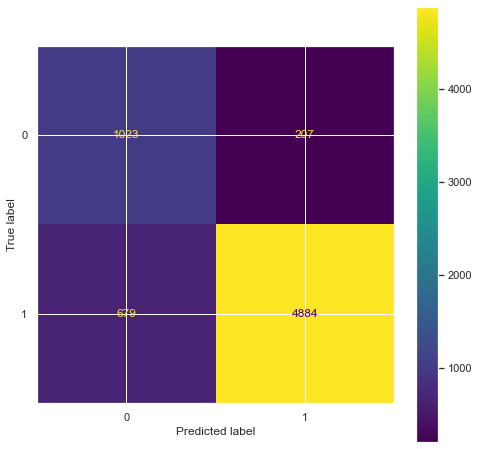

In [121]:
print("SVC MODEL")

model_evaluation(svc, X_train_count, X_test_count)

13.3.b Support Vector Machine (SVM) With TF-IDF Vectorizer

In [122]:
svc2 = LinearSVC(C=0.01, class_weight="balanced", random_state=101)

svc2.fit(X_train_tf_idf, y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

SVC MODEL 2
Test_Set
              precision    recall  f1-score   support

           0       0.55      0.86      0.67      1230
           1       0.96      0.85      0.90      5563

    accuracy                           0.85      6793
   macro avg       0.76      0.85      0.79      6793
weighted avg       0.89      0.85      0.86      6793

Train_Set
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      2871
           1       0.97      0.85      0.91     12977

    accuracy                           0.85     15848
   macro avg       0.77      0.87      0.80     15848
weighted avg       0.90      0.85      0.87     15848



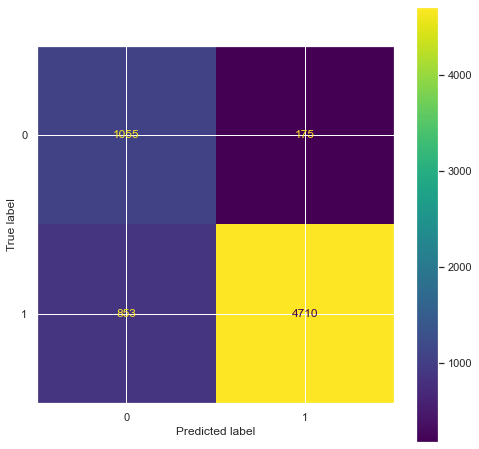

In [123]:
print("SVC MODEL 2")

model_evaluation(svc2, X_train_tf_idf, X_test_tf_idf)

13.4 - Random Forest

13.4.a Random Forest With Count Vectorizer

In [124]:
rf = RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       n_jobs=-1, random_state=42)

RF MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.56      0.77      0.65      1230
           1       0.94      0.87      0.91      5563

    accuracy                           0.85      6793
   macro avg       0.75      0.82      0.78      6793
weighted avg       0.88      0.85      0.86      6793

Train_Set
              precision    recall  f1-score   support

           0       0.65      0.89      0.75      2871
           1       0.97      0.89      0.93     12977

    accuracy                           0.89     15848
   macro avg       0.81      0.89      0.84     15848
weighted avg       0.92      0.89      0.90     15848



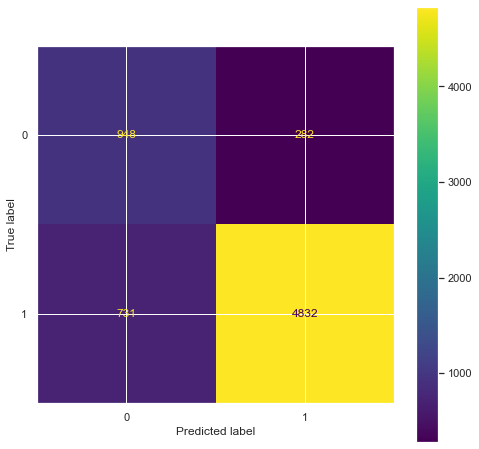

In [125]:
print("RF MODEL")

model_evaluation(rf, X_train_count, X_test_count)

13.4.b Random Forest With TF-IDF Vectorizer

In [126]:
rf2 = RandomForestClassifier(200, max_depth = 10, random_state = 42, n_jobs = -1, class_weight="balanced")

rf2.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

RF MODEL 2
Test_Set
              precision    recall  f1-score   support

           0       0.55      0.76      0.64      1230
           1       0.94      0.86      0.90      5563

    accuracy                           0.84      6793
   macro avg       0.75      0.81      0.77      6793
weighted avg       0.87      0.84      0.85      6793

Train_Set
              precision    recall  f1-score   support

           0       0.62      0.89      0.73      2871
           1       0.97      0.88      0.92     12977

    accuracy                           0.88     15848
   macro avg       0.80      0.88      0.83     15848
weighted avg       0.91      0.88      0.89     15848



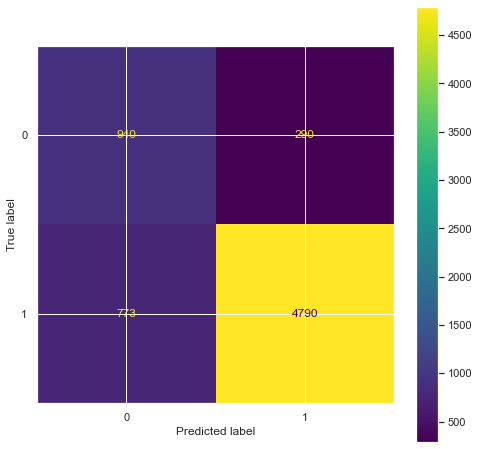

In [127]:
print("RF MODEL 2")

model_evaluation(rf2, X_train_tf_idf, X_test_tf_idf)